In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

# Define Simulation functions

## Simulate Spatial Noise

In [5]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

Takes a layer, rotates by angle. Next, we map all coordinates to closest integer coordinates.

This removes some points as two points who share the same closest integer pair will map to same coordinate.

In [6]:
def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()

    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

## Simulate Gene Expression

In [7]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

## Define Center Simulation

Given an initial layer, we simulate three layers by perturbing spatial and gene expression information. Then, we run center align and report the average % of spots preserved between the simulated layers and the initial layer.

In [8]:
def sim(base_layer, p, alpha):
    base_layer = base_layer.copy()
    # the following block of code is if you want your initial layer to be low dimensional
    # model = NMF(n_components=15, solver = 'mu', init='random', beta_loss = 'kullback-leibler')
    # W = model.fit_transform(base_layer.X)
    # H = model.components_
    # base_layer.X = pd.DataFrame(np.dot(W, H))
    sim_layers = []
    maps = []
    theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
    for i in range(3):
        adata_layer_sim_spatial, mappings = simulate_spatial(base_layer, theta_angles[i])
        adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = p)
        sim_layers.append(adata_layer_sim_both)
        maps.append(mappings)
    
    lmbda = len(sim_layers)*[1/len(sim_layers)]
    base_layer = simulate_gene_exp(base_layer, pc = p)
    center_slice, pis = paste.center_align(base_layer, sim_layers, lmbda, alpha = alpha, n_components= 15)
    
    result = []
    for m, p in zip(maps, pis):
        s = 0
        for i in range(len(m)):
            s += p[m[i]][i]
        result.append(s)
    return result


# Run simulations

## Read in data

In [9]:
def load_breast_layer(path):
    X = pd.read_csv(path, index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [10]:
layer1_path = "../data/Stahl-BC/stahl_bc_slice1.csv" 
layer2_path = "../data/Stahl-BC/stahl_bc_slice2.csv"
layer3_path = "../data/Stahl-BC/stahl_bc_slice3.csv"
layer4_path = "../data/Stahl-BC/stahl_bc_slice4.csv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

## Generate Results

In [14]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

In [15]:
path_to_output_dir = '../data/Stahl-BC/cached-results/center-sim/center-align/'

if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)

In [23]:
# Number of runs per experiment
N_RUNS = 10
pseudocounts = [0, 1, 2, 3, 4, 5]

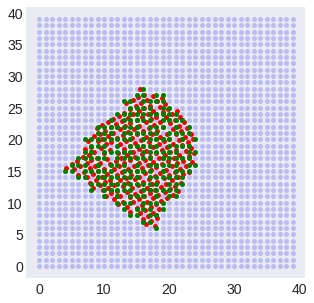

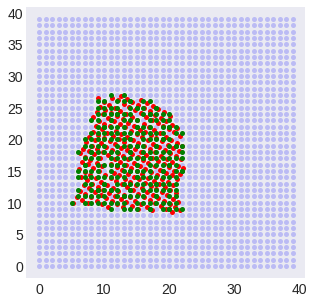

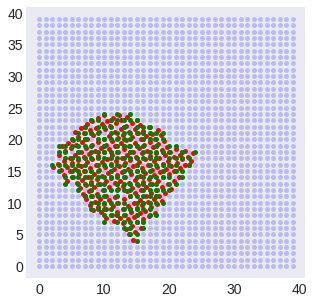

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.938201213620952

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.039815496050015

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping 

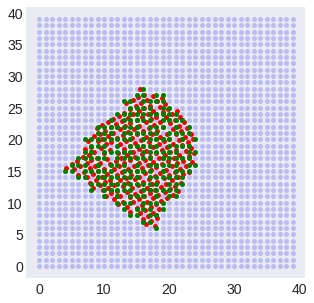

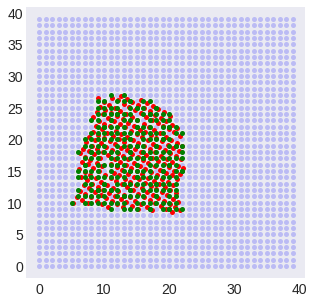

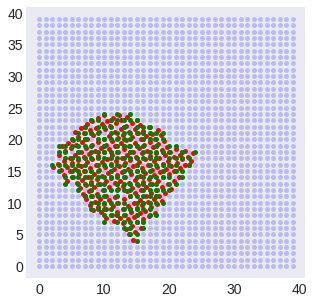

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.073199802114068

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0871302192981227

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping

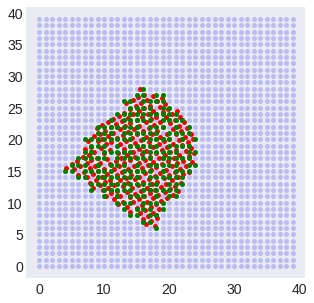

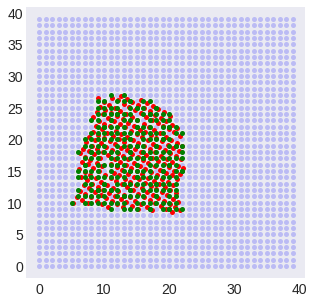

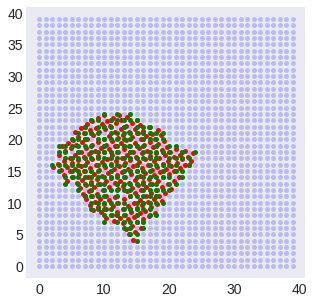

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



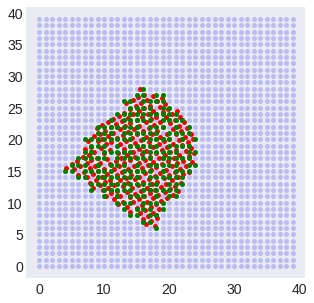

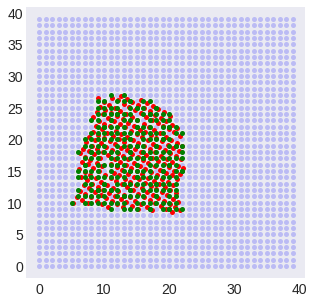

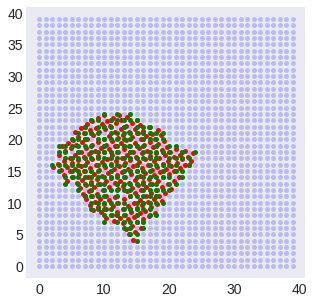

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8217617034840887

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.145893877360872

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00013999306389411714



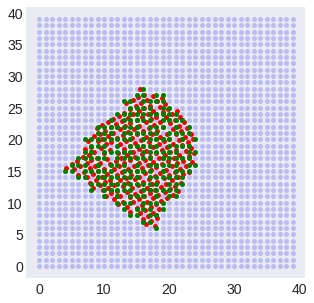

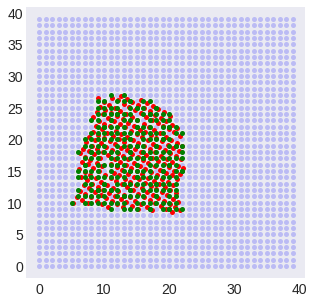

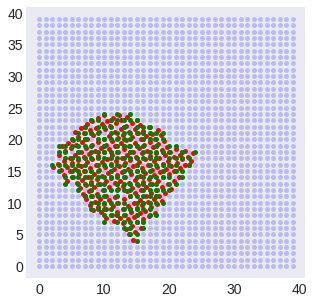

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9457544160363347

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13578109135218308

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0023334894499855707

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0009058947143569807



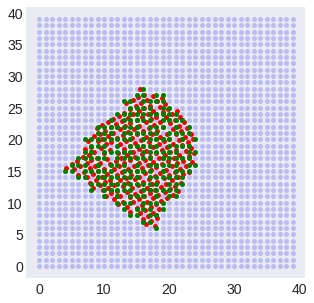

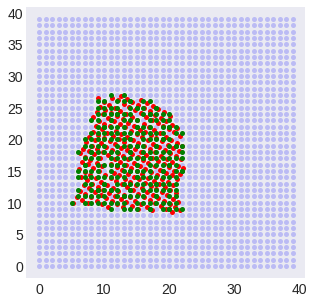

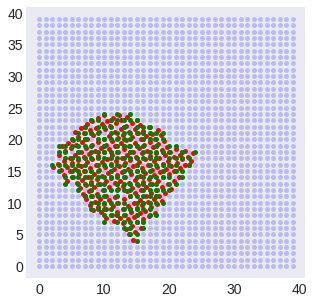

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



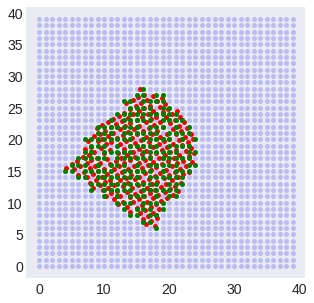

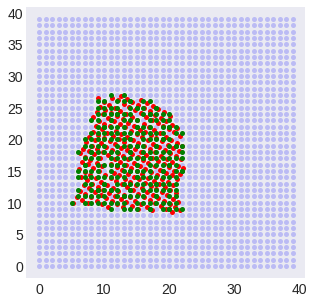

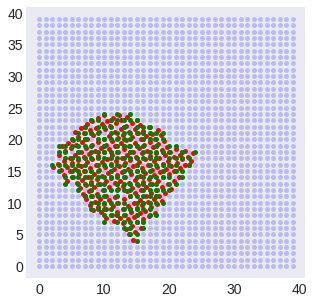

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8506830589466623

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1525000361431832

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000599936373065546



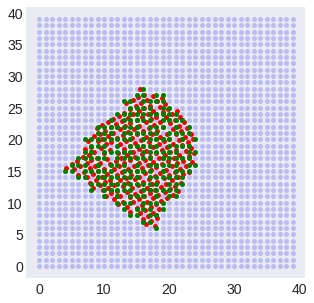

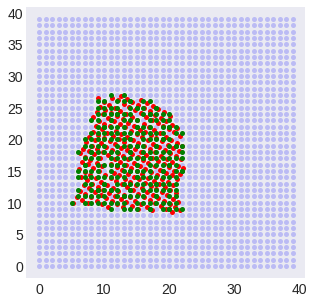

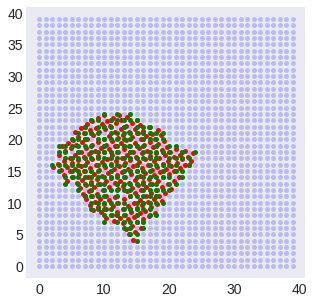

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9810468852794623

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1555411423152837

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002104267404837268

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015491896159227636

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015379143472749046

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0010615450837356821

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00021860191715150634



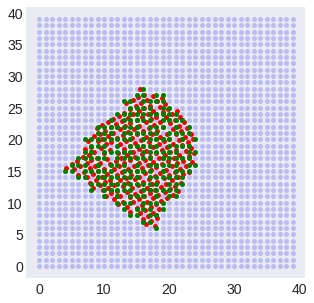

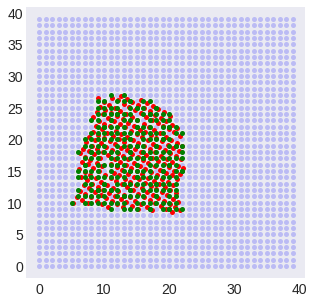

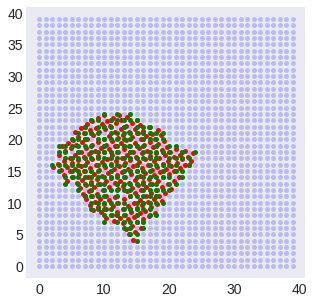

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



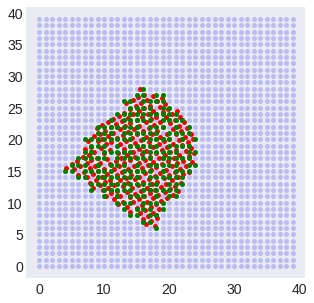

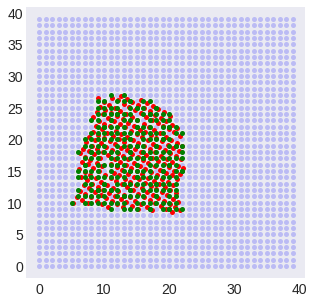

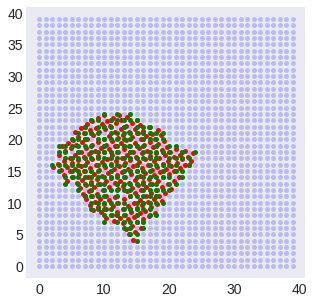

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8805328890008617

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1688363577711629

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017698173855211774

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001142653084944767

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.057498245781723e-05



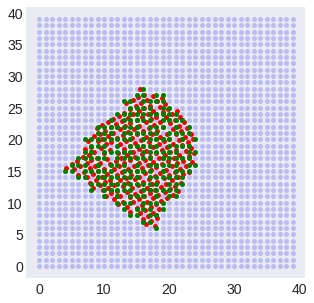

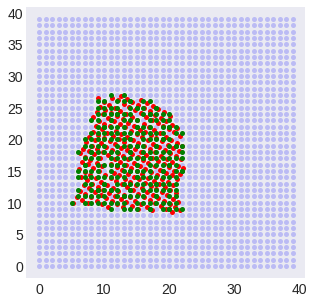

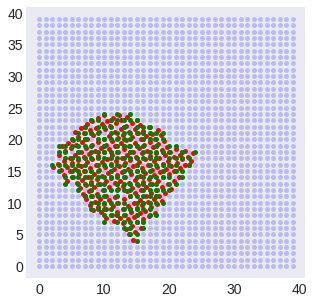

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.027886275311106

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.17049227040360782

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0037893707971397017

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001918410971740503

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0022365736078433507

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.384452992036493e-05



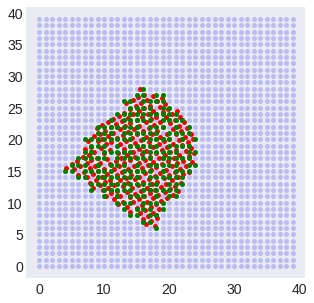

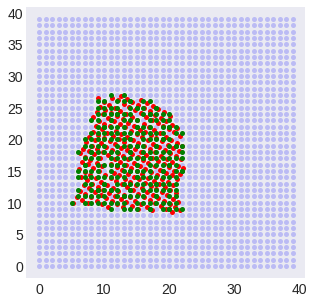

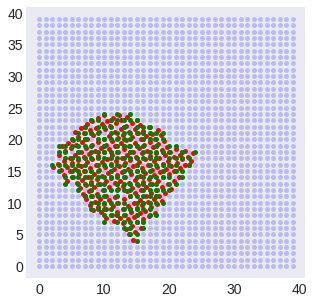

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



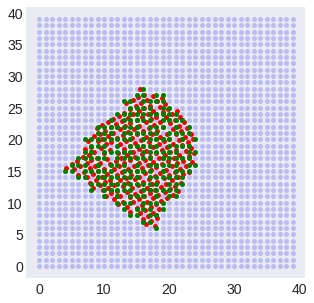

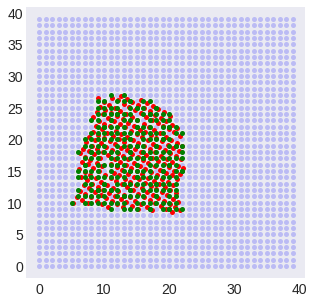

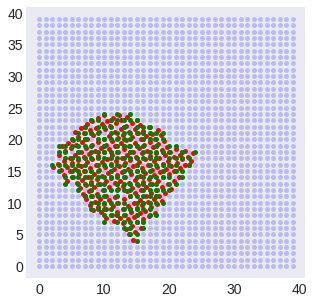

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8840947301344149

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15098793766831298

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0003669213208994382



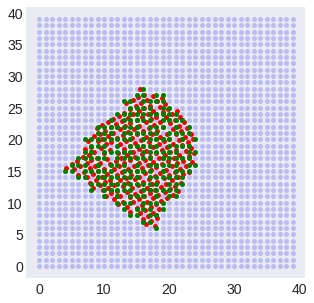

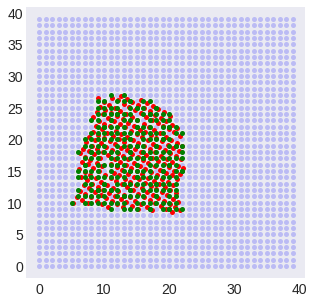

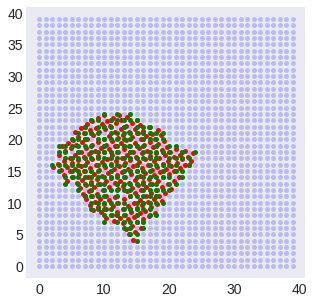

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.999436765263583

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16437918872053148

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006082858268223745



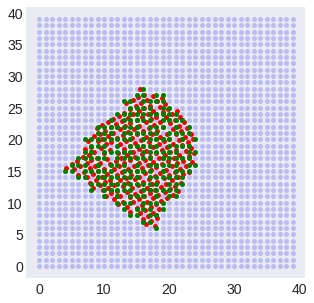

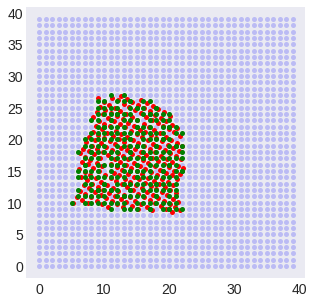

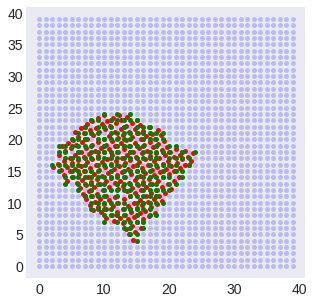

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



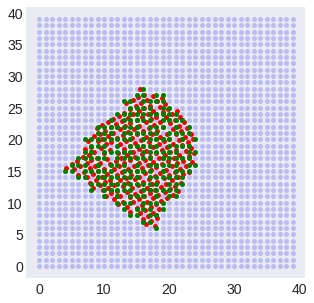

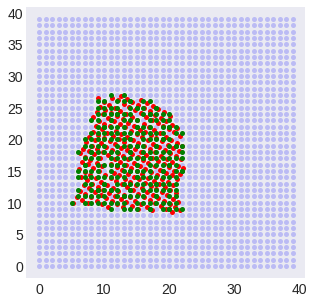

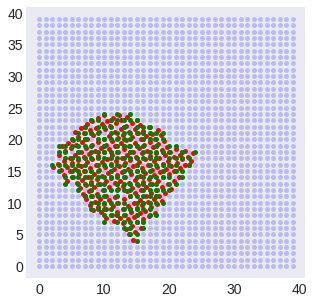

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.877313624962243

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15379811608575822

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0010613974397088999

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004977686281617544



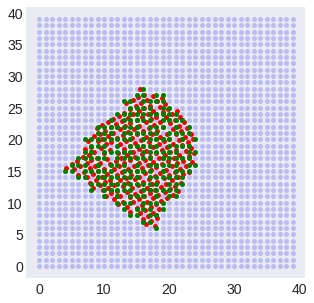

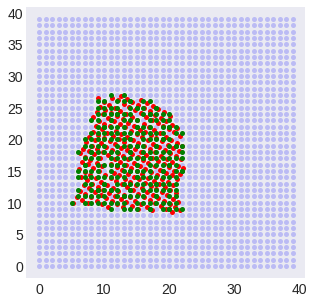

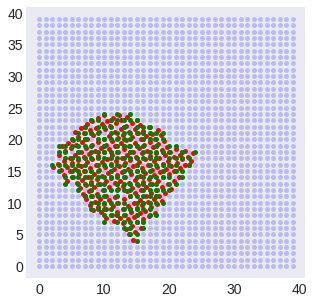

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.0089976286171405

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1595232734835701

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000796099044759524



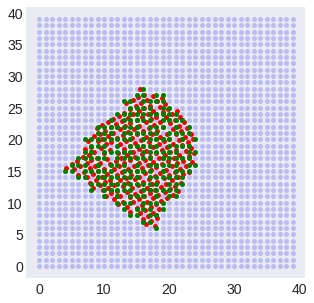

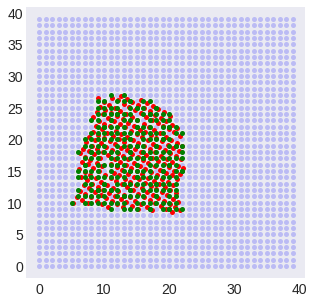

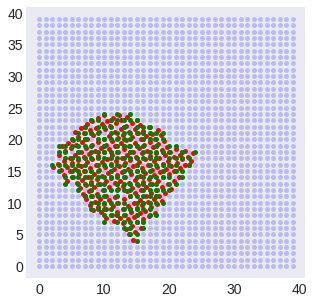

Filtered all slices for common genes. There are 14880 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.43474634699006787

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



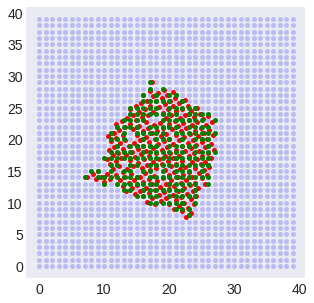

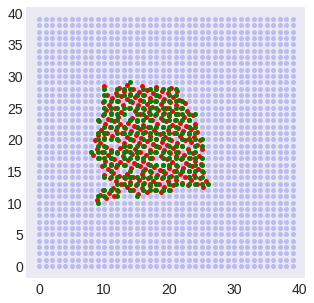

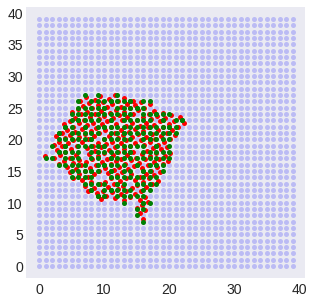

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.933882457033385

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.06715989801289268

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mappin

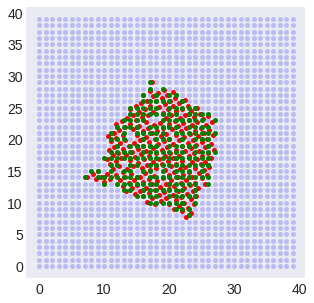

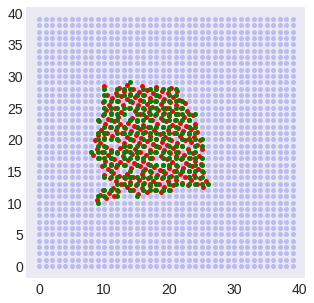

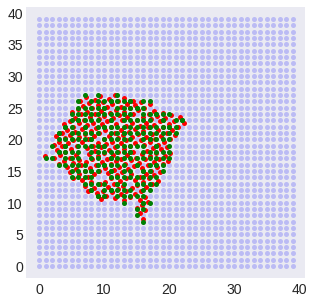

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.0398881728531486

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0486740519788218

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mappin

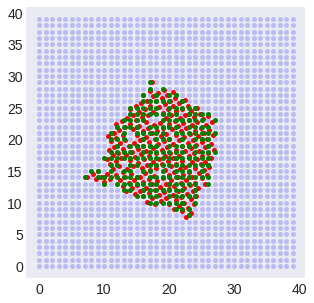

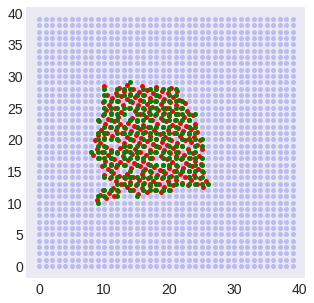

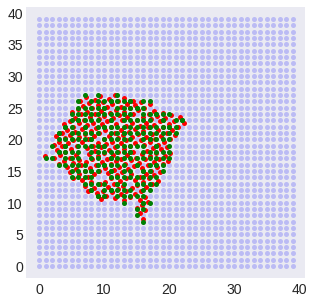

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 6.794564910705958e-14



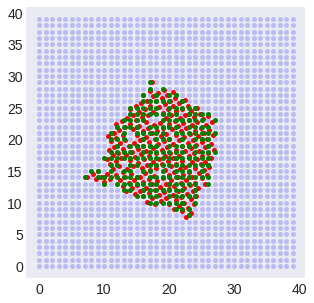

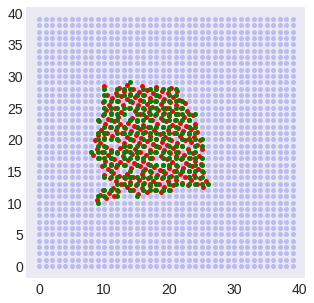

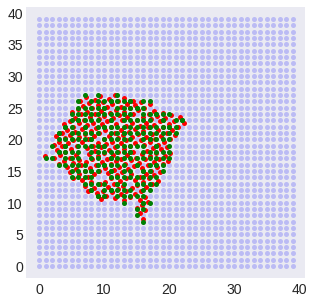

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.814133563969264

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15437198307348599

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0008848508486332118



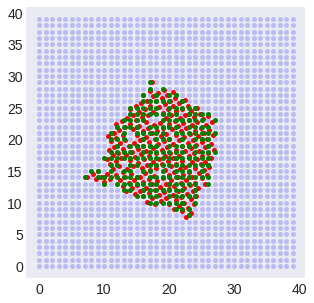

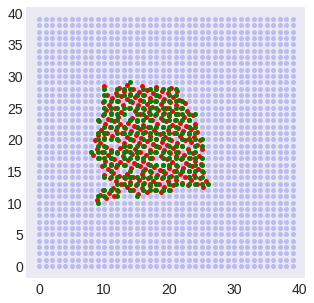

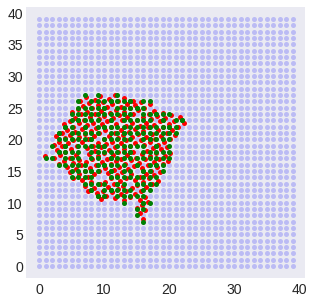

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9624269859545662

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13384181214863156

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0022695282076921064

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006743848627608351



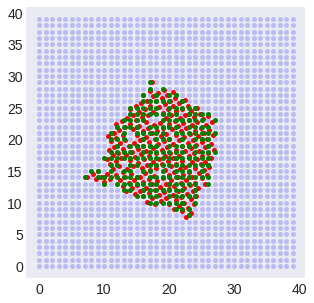

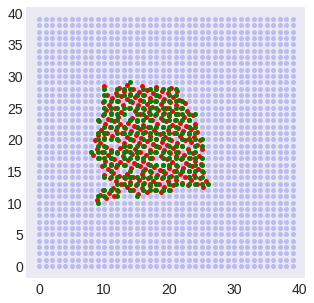

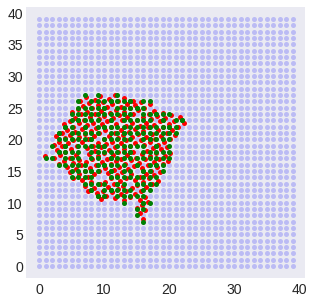

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.794564910705958e-14



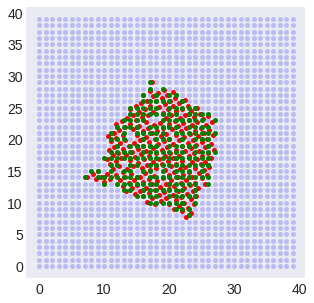

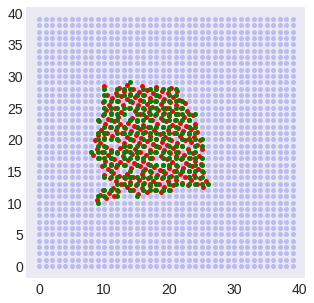

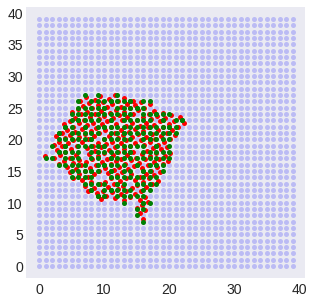

Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8937414927536647

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1520394550847064

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001671821639231963

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00041050033936373964



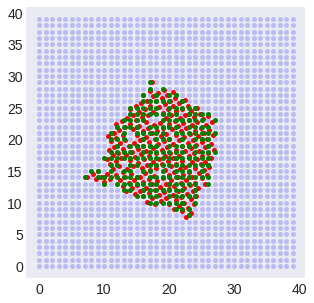

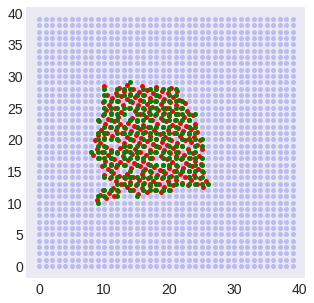

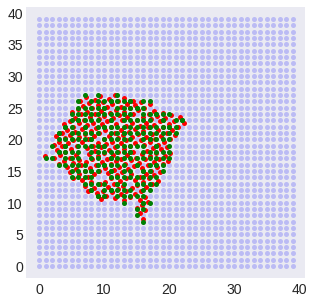

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9822717272917614

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1539401823423341

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00044700608224546023



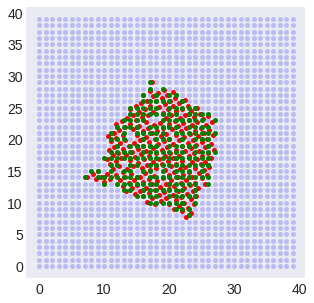

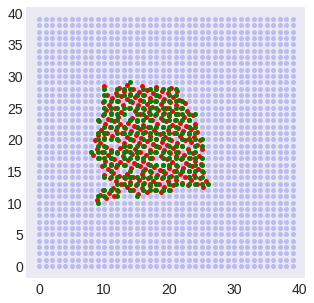

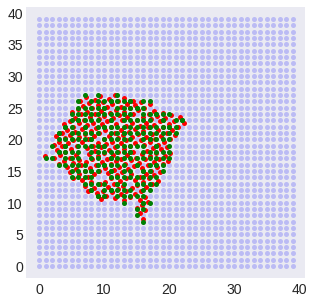

Filtered all slices for common genes. There are 14789 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.794564910705958e-14



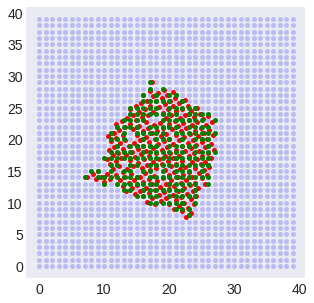

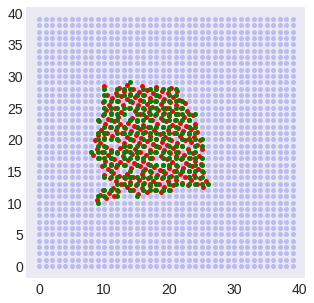

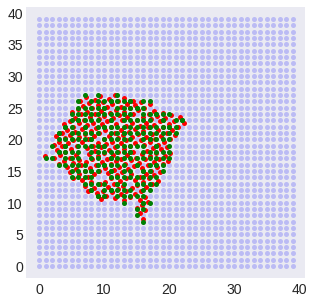

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8529841471680242

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15686615134151927

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001233988322458579

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0006662781502124737



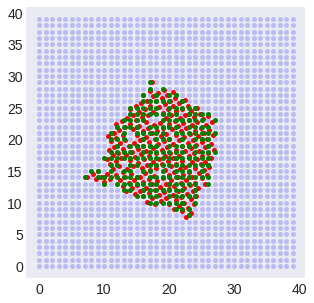

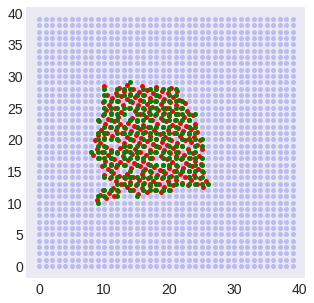

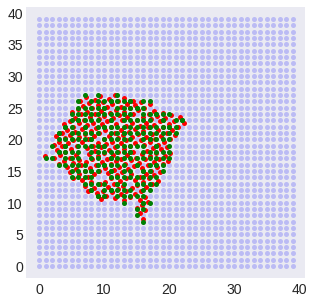

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.009962880283428

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1735106153491579

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0005629977736976155



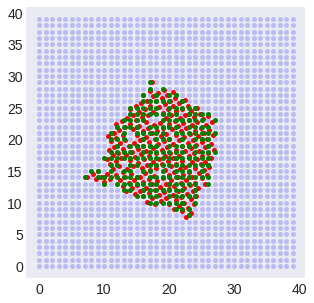

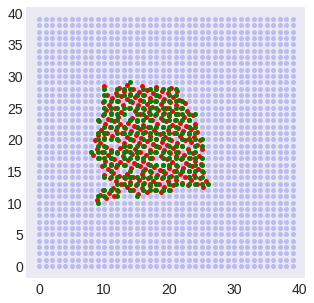

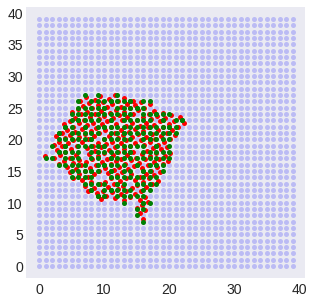

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.794564910705958e-14



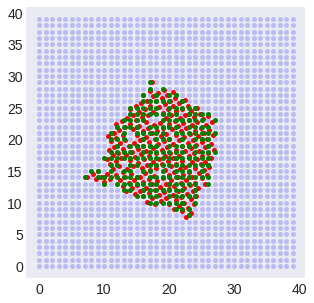

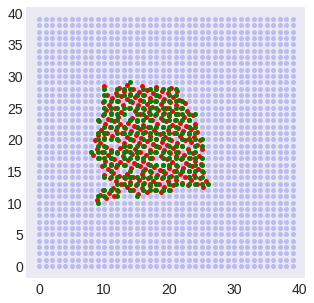

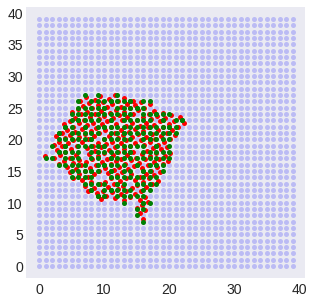

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8550969280512786

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16379437772468197

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 7.226659234382815e-05



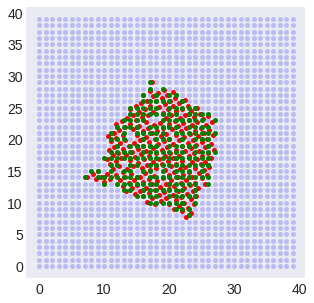

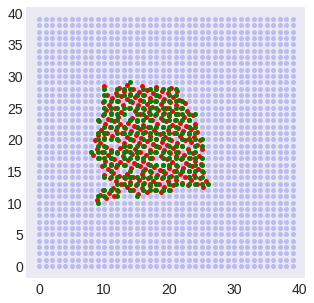

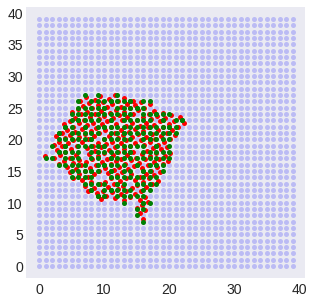

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.014677110968992

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1658497672093615

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002950603032543686

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007365597743544949



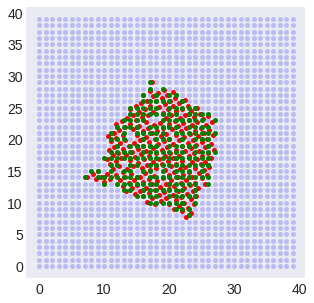

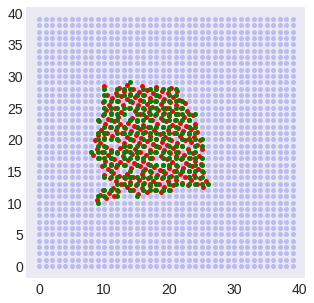

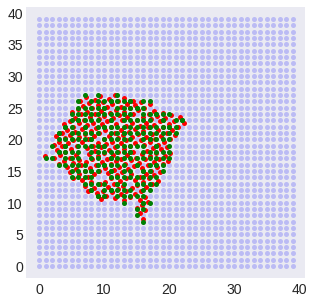

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.794564910705958e-14



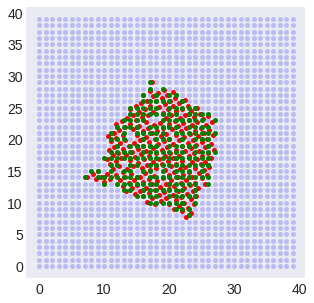

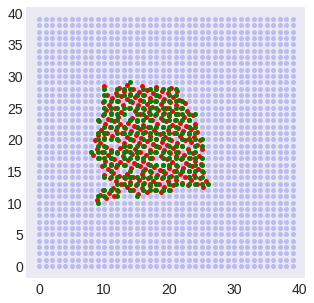

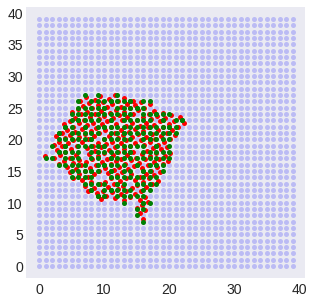

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8755730367944845

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15588538367839844

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00027871653771960325



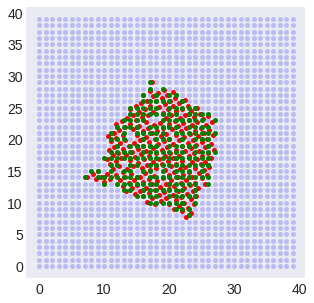

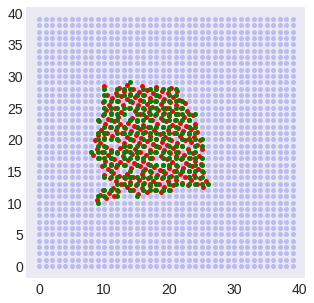

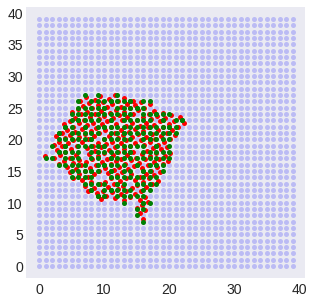

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.03096839407794

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.16810445642316774

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0021122444660033324

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012320701343182527

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0019429780562369992

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0015563238956646241

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004268179705306796



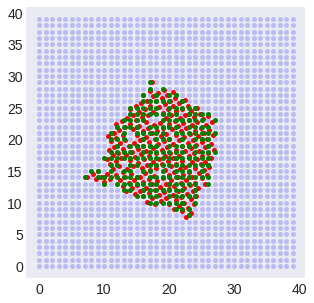

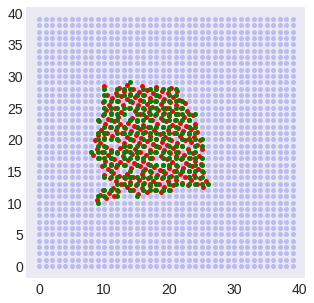

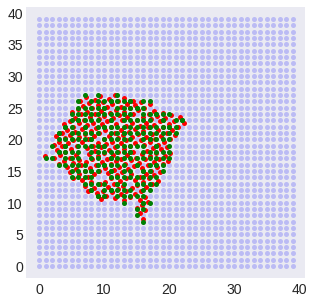

Filtered all slices for common genes. There are 14789 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8066826695582464

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.794564910705958e-14



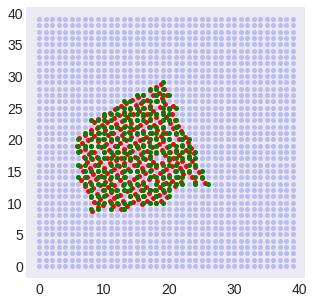

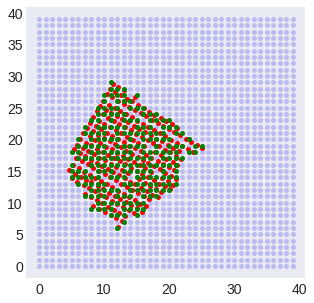

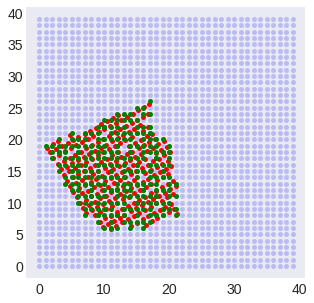

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.8870839871902048

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.04460599456733205

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mappi

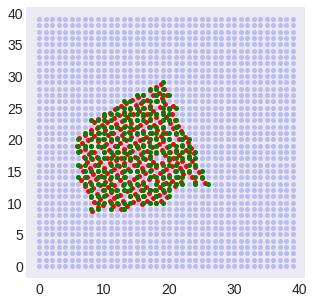

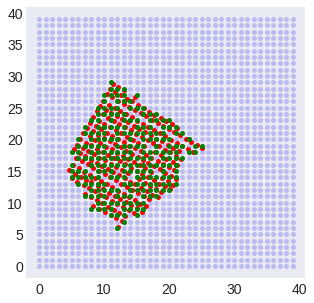

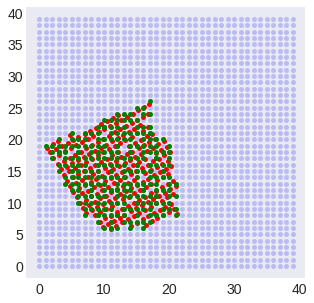

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 2.0385962520481424

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0993673927889358

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mappin

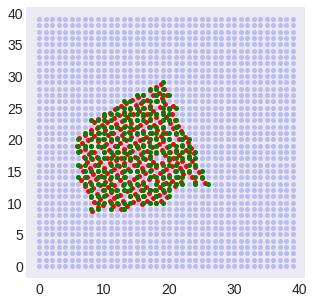

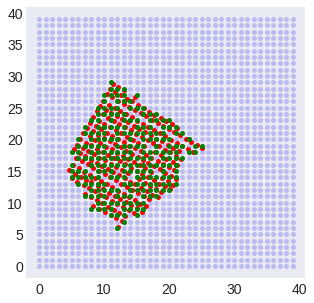

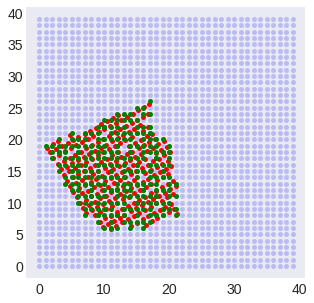

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 8.326672684688674e-14



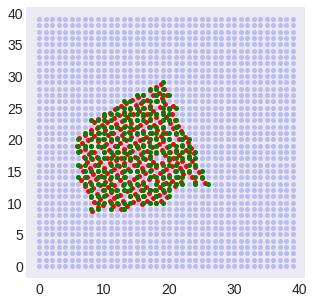

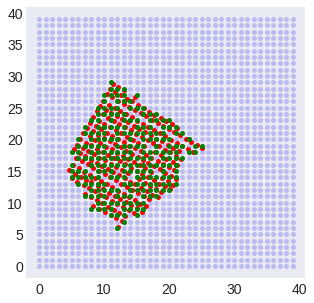

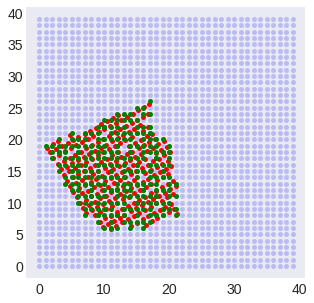

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.7409362188879283

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.13621962371972018

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0005915250102603853



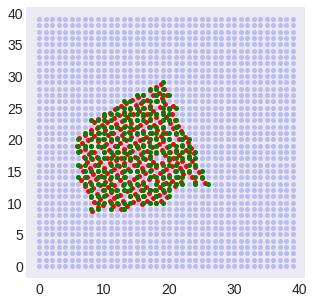

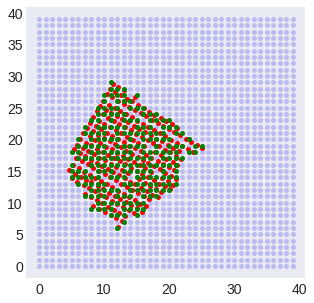

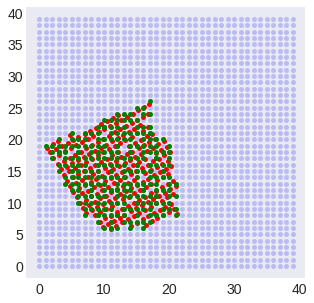

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.8909897957413313

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15076485428647635

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0030968322118727354

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00013270251337926808



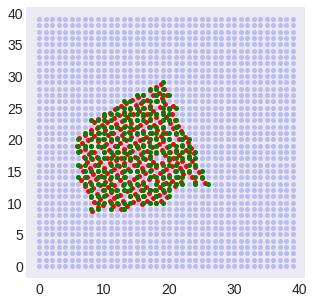

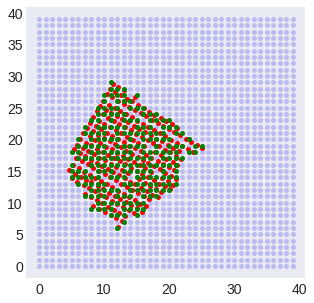

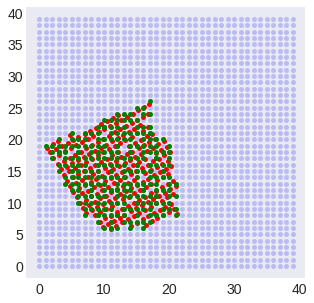

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.326672684688674e-14



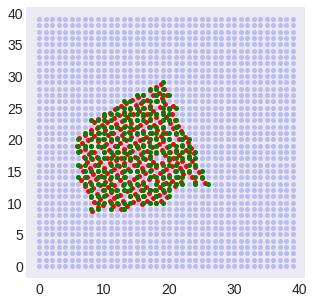

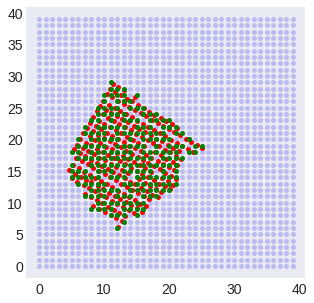

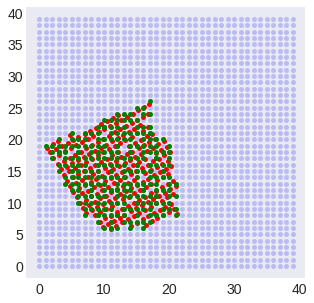

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.790337058701498

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15435671552199337

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00026054987149826125



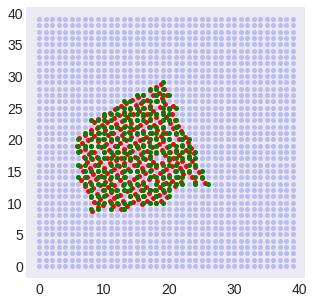

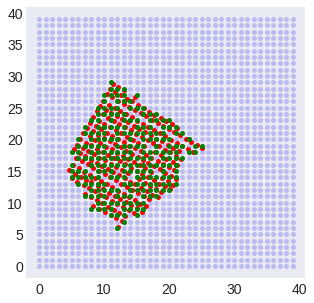

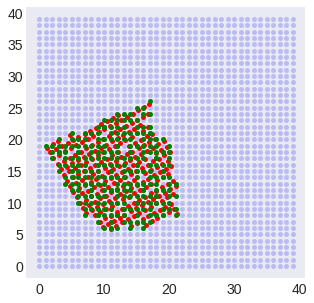

Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9218274048033086

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.17702553109124297

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 6.552947083804384e-05



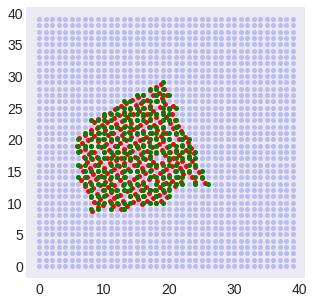

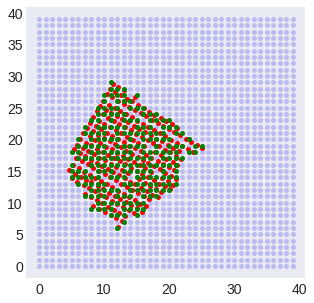

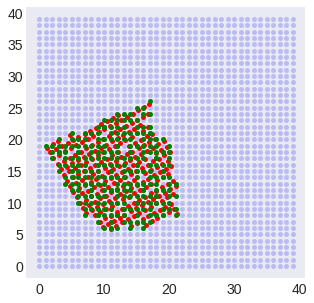

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.326672684688674e-14



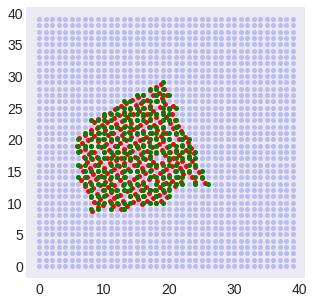

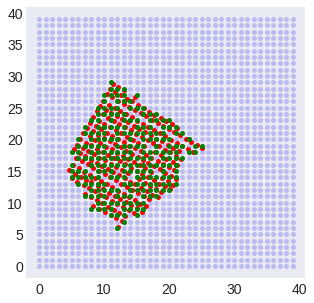

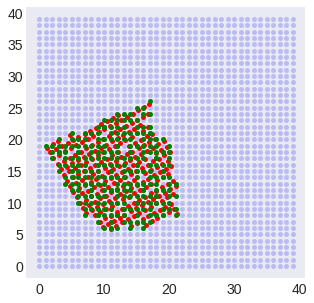

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.752832307574858

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14989522069278993

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011881654208745207

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0002817101666909849



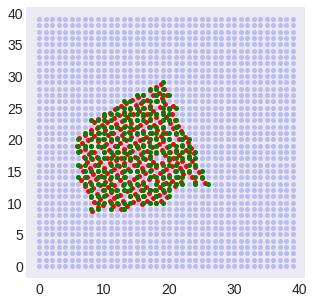

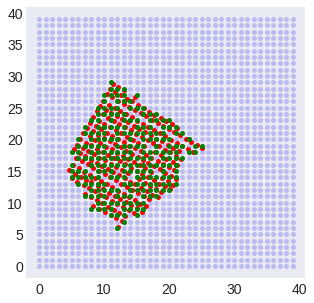

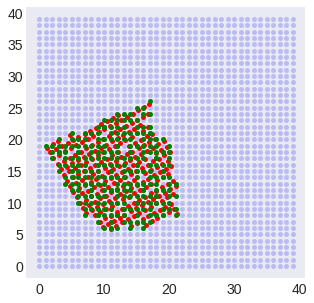

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.954281018955675

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.17089824164235257

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0001708126985042746



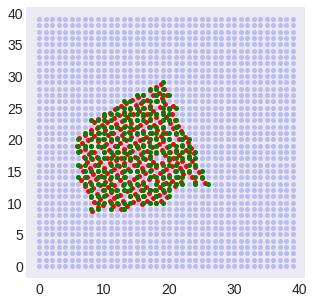

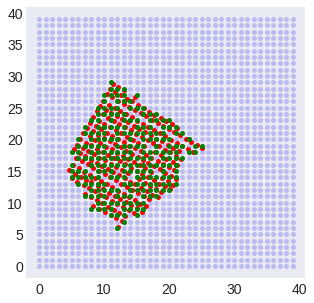

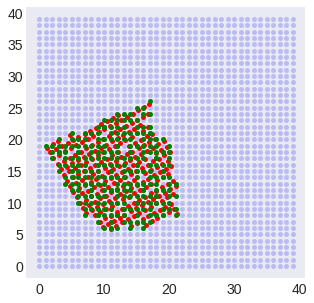

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.326672684688674e-14



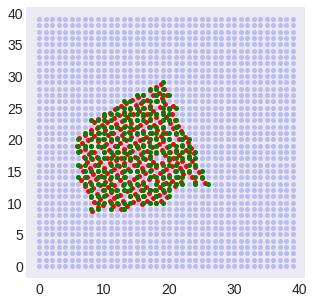

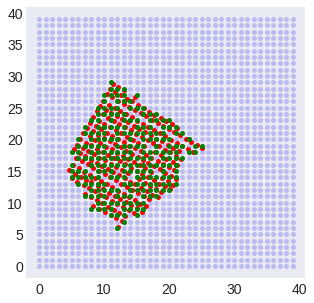

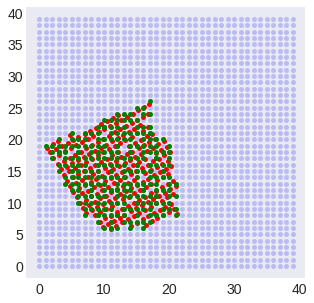

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.78077301898102

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14290311575581938

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0011749518768944256

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000132681171941762



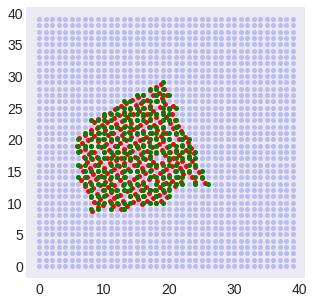

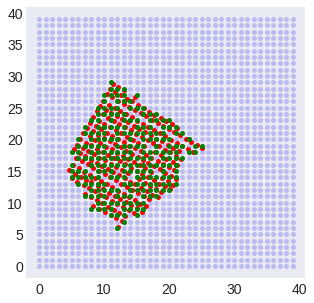

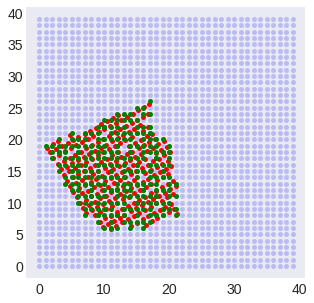

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.9183113302428219

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1718521219560929

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00012816295312023662



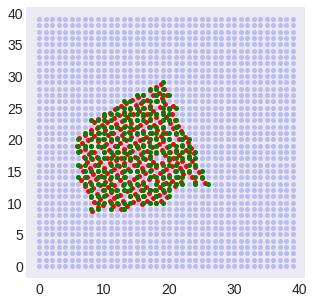

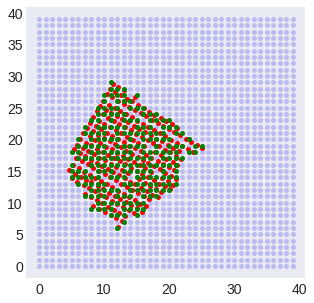

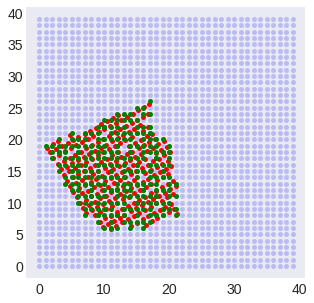

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.326672684688674e-14



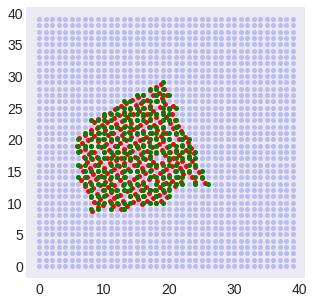

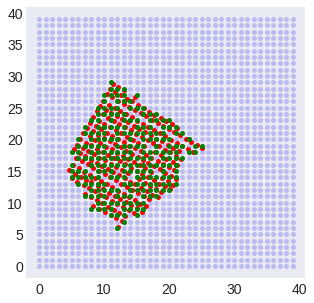

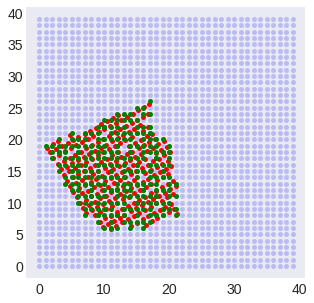

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.7897705585814685

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1470871407448835

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004059916964957999



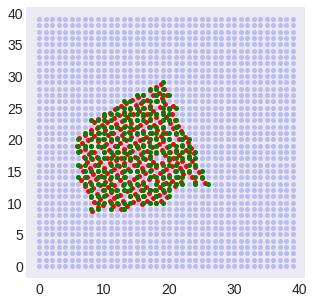

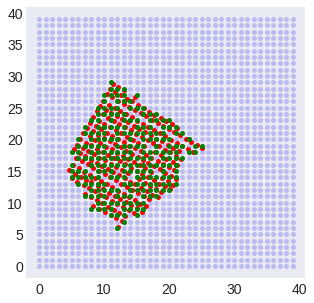

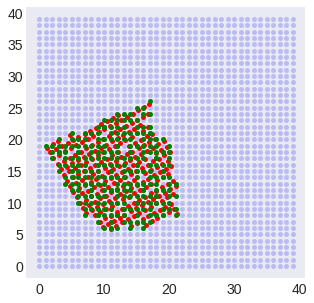

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.916664514523729

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1502924075056522

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0001822671268894016



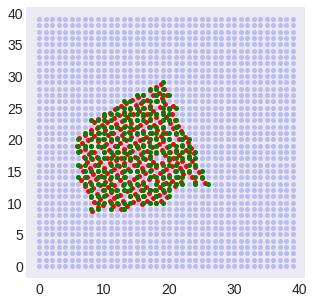

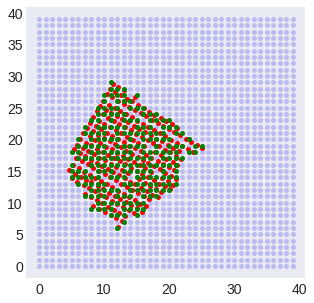

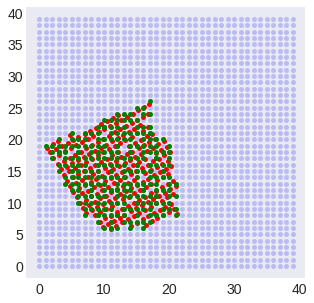

Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.8522712283624467

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 8.326672684688674e-14



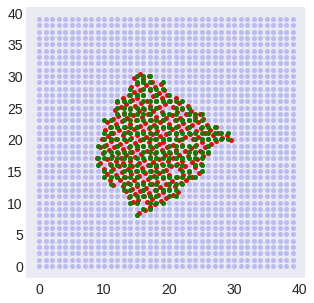

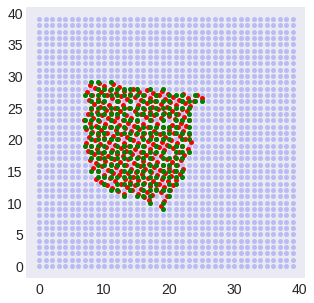

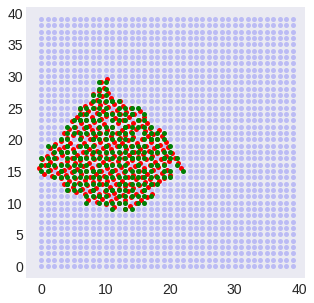

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.8147381685799928

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.019381487779567053

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapp

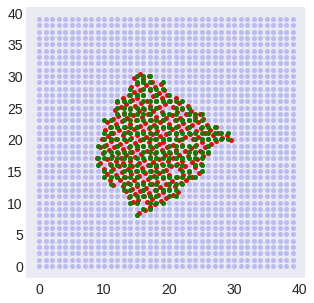

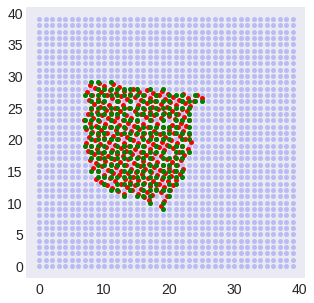

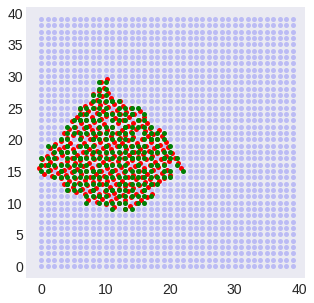

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.877860166617445

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.07418134737807147

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mappin

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.004926075029081378

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.001063657466582324

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.008017010889364462

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.006

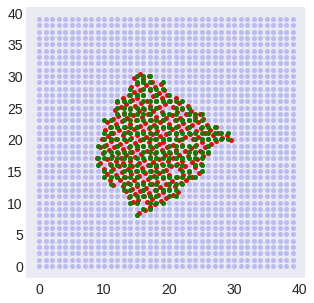

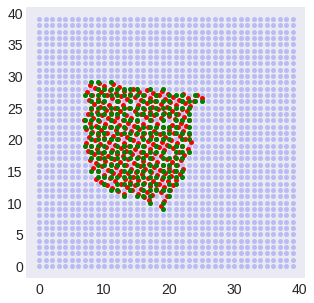

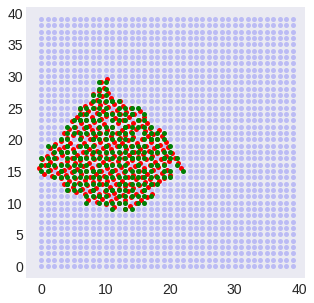

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



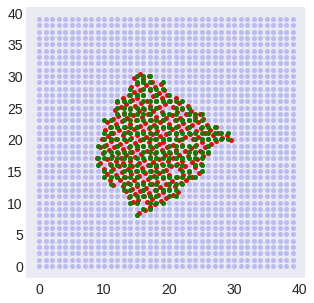

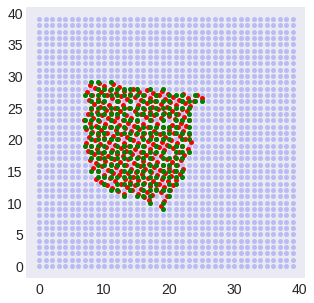

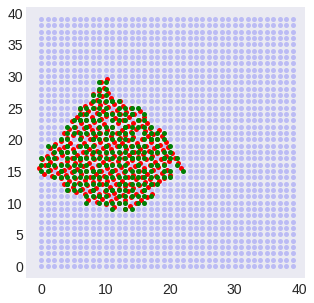

Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.554847409051685

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.10906695395414934

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002162314591949155

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017257827684320493

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007256382966491781



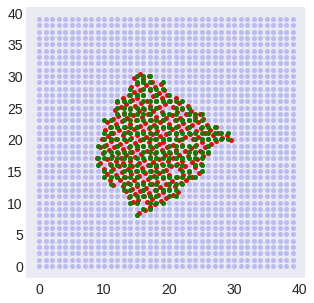

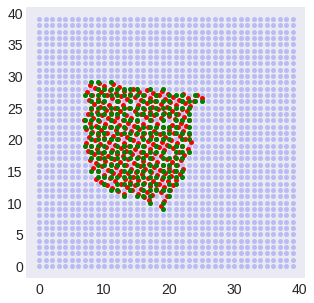

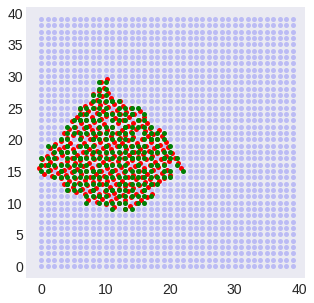

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.6853810921453118

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1379484305318568

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.000993152805029096



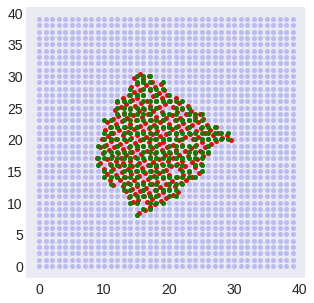

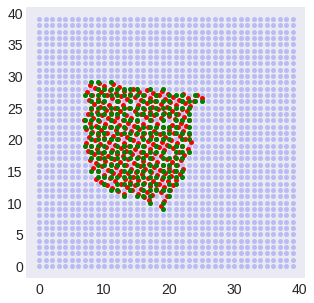

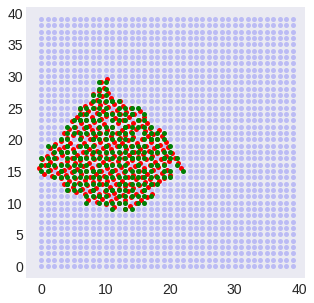

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



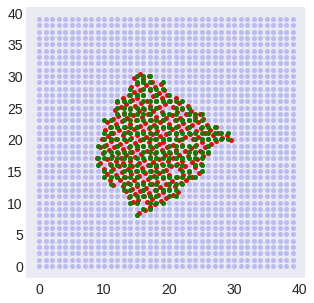

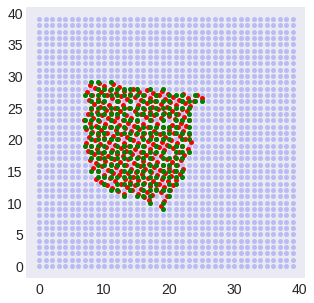

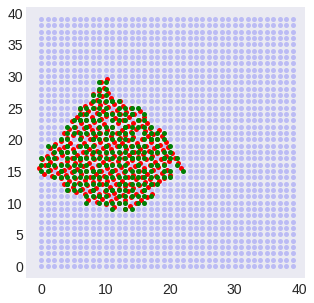

Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.5232011435637243

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.11754229315613252

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0021440185385011024

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012274123615663157

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00047992079360525963



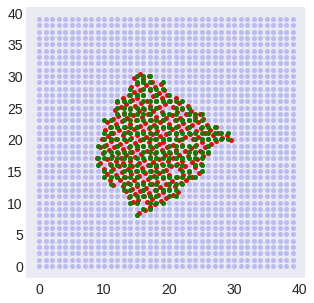

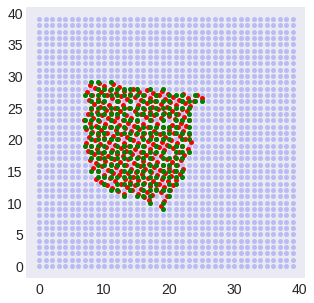

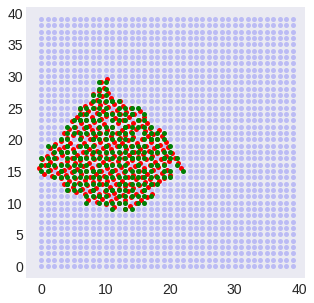

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.6584466576225612

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.12466727708693259

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0031429502017383815

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.00040847325682724644



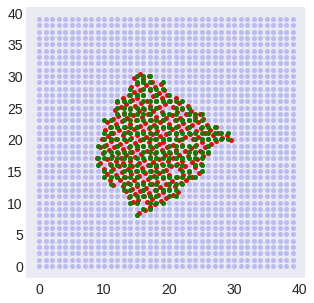

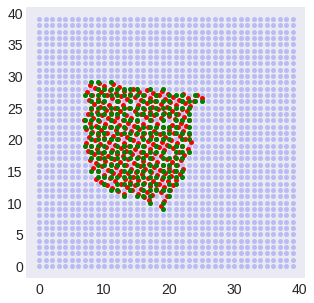

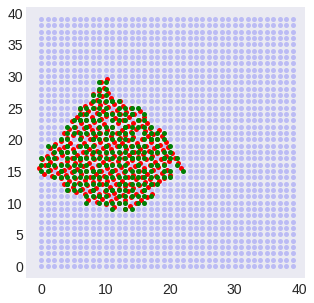

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



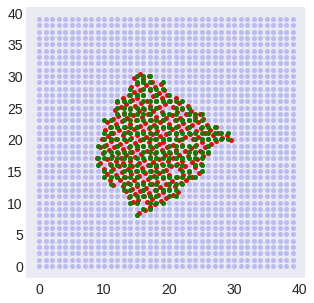

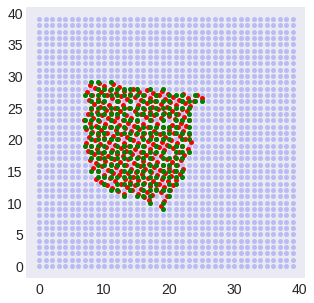

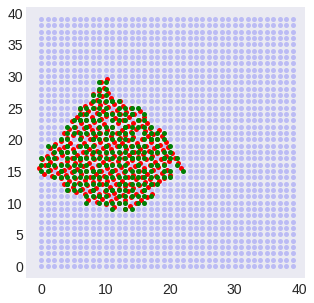

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.5892130057238196

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14513975562405124

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007582144253650558



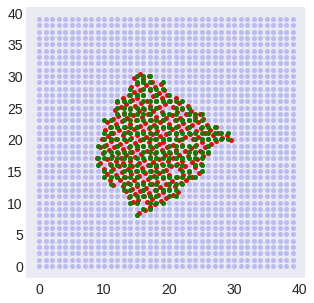

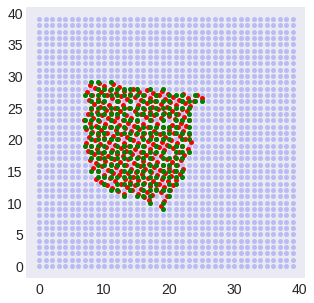

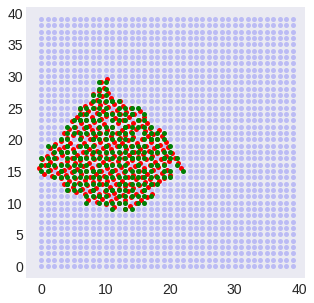

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.7465431583902302

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.15320406432966904

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017647091550567762

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0007635270952732753



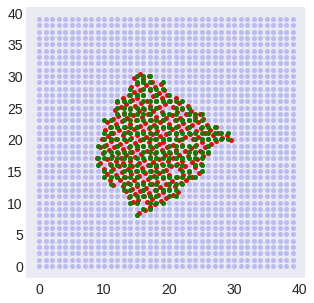

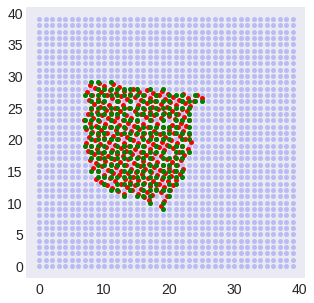

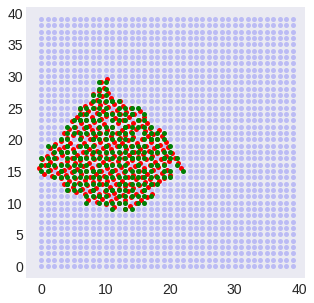

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



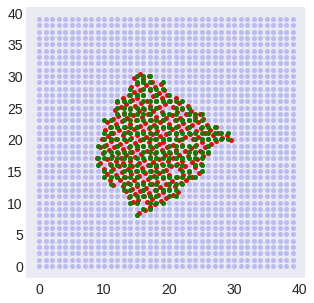

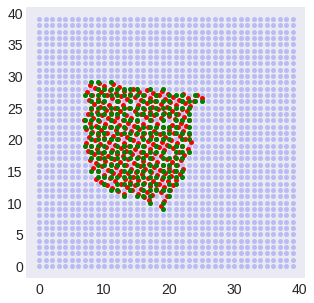

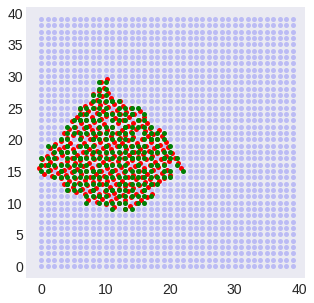

Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.5863250303306171

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.12452292481135219

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.002218277236322397

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0018056776634201022

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.001005180073969436

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0004208859824588185



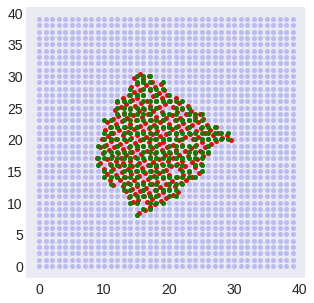

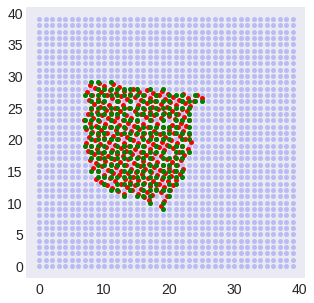

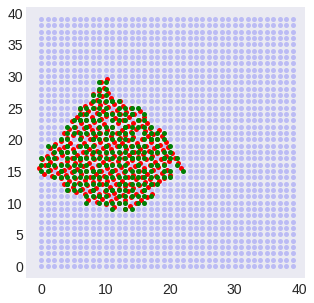

Filtered all slices for common genes. There are 14808 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.6437937052964862

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.1239451990932725

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0017714943074891298

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0012112911416441996

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0002444692894181255



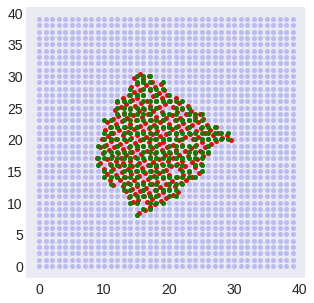

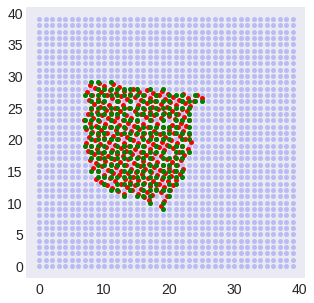

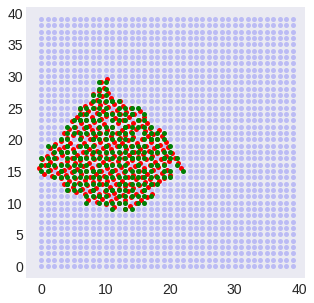

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0



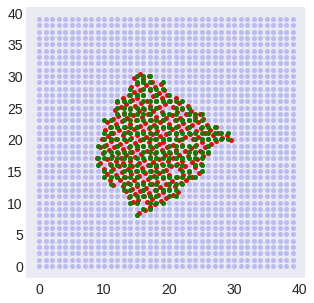

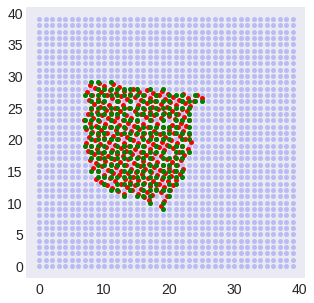

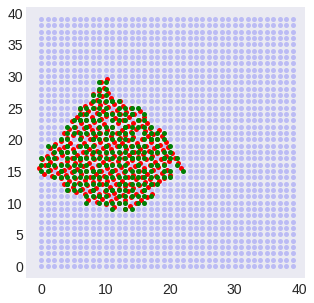

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.6349714396576918

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14550877590730527

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.0008078954028187812



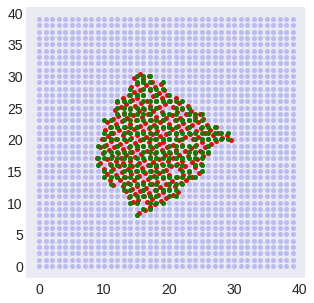

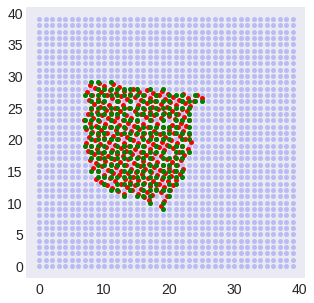

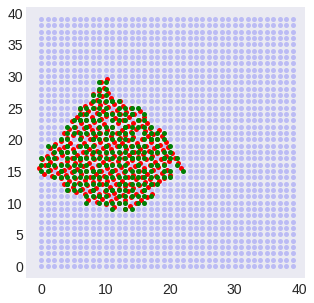

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 1.7412660255670174

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.14124398778534708

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 2.468818375245263e-05



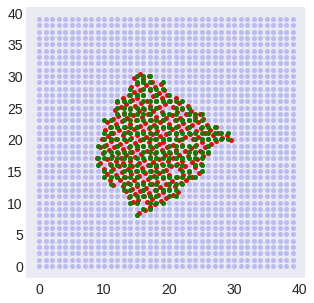

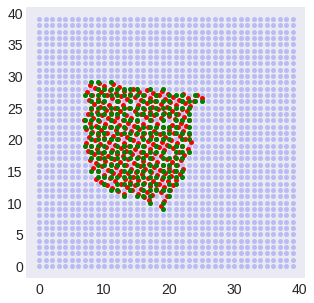

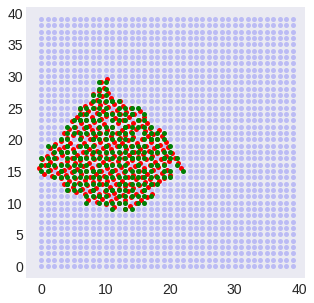

Filtered all slices for common genes. There are 14808 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.34367423569396083

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0



/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [24]:
for slice_name, adata in slices.items():
    baseline_runs = []
    mixed_runs = []
    spatial_runs = []
    for i in range(N_RUNS):
        mixed = []
        baseline = []
        spatial = []
        mixed_acc = []
        baseline_acc = []
        spatial_acc = []
        for p in pseudocounts:
            m = sim(adata, p, 0.1)
            b = sim(adata, p, 0)
            s = sim(adata, p, 1)
            mixed.append(m)
            baseline.append(b)
            spatial.append(s)
        baseline_runs.append(np.mean(baseline, axis=1))
        mixed_runs.append(np.mean(mixed, axis=1))
        spatial_runs.append(np.mean(spatial, axis=1))
        df = pd.DataFrame([np.mean(baseline_runs, axis = 0), np.mean(mixed_runs, axis = 0), np.mean(spatial_runs, axis = 0)],
                     index = ['gene-expression', 'mixed', 'spatial'], columns = pseudocounts)
        df.to_csv(path_to_output_dir + slice_name + '.csv')

## Plot Results for simulation.

In [2]:
path_to_output_dir = '../data/Stahl-BC/cached-results/center-sim/center-align/'

# Max accuracy cached from pairwise sim
max_acc = {
    'SliceA': 0.8661, 
    'SliceB': 0.8764,
    'SliceC': 0.8598, 
    'SliceD': 0.8816
}

result_dfs = {}

for s in ['SliceA', 'SliceB', 'SliceC', 'SliceD']:
    df = pd.read_csv(path_to_output_dir + s + '.csv', index_col= 0)
    result_dfs[s] = df

Slice B

C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

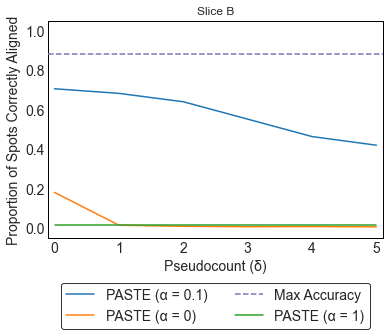

In [3]:
df = result_dfs['SliceB']
ax = sns.lineplot(df.columns, df.loc['mixed'], label = "PASTE (α = 0.1)")
ax = sns.lineplot(df.columns, df.loc['gene-expression'], label = "PASTE (α = 0)")
ax = sns.lineplot(df.columns, df.loc['spatial'], label = "PASTE (α = 1)")
ax.axhline(max_acc[s], linestyle='--', label = 'Max Accuracy', c = '#8172b2')
ax.set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_xlabel('Pseudocount (δ)', fontsize = 14)
ax.set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
ax.set(title = 'Slice B')
h, l = ax.get_legend_handles_labels()
handles = [h[0],h[1],h[3],h[2]] 
labels = [l[0],l[1],l[3],l[2]] 
ax.legend(handles, labels, loc= 'lower center', bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=True, edgecolor='black', facecolor='white', fontsize=14)
plt.show()

All Slices

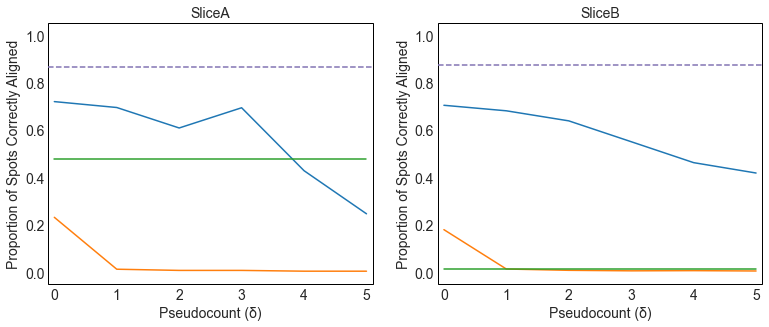

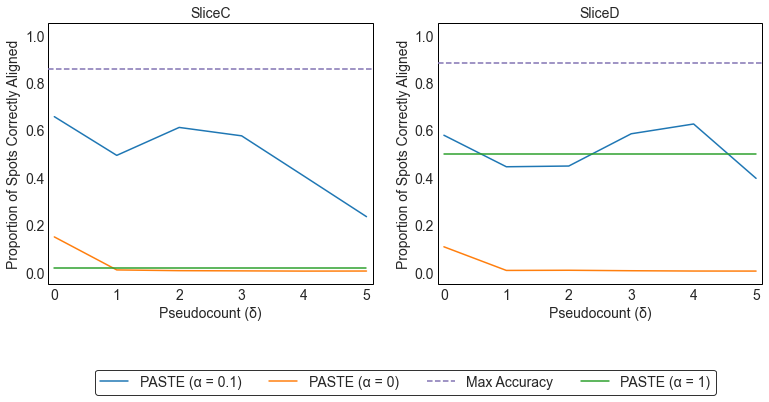

In [4]:
f, ax = plt.subplots(1,2, figsize=(12.8, 4.8))
f1, ax1 = plt.subplots(1,2, figsize=(12.8, 4.8))
# Setting the values for all axes.
plt.setp(ax, xlim=(-0.1,5.1), ylim=(-0.05,1.05))

for a, s in zip([ax[0], ax[1], ax1[0], ax1[1]],  result_dfs.keys()):
    df = result_dfs[s]
    a.plot(df.columns, df.loc['mixed'], label = "PASTE (α = 0.1)")
    a.plot(df.columns, df.loc['gene-expression'], label = "PASTE (α = 0)")
    a.plot(df.columns, df.loc['spatial'], label = "PASTE (α = 1)")
    a.axhline(max_acc[s], linestyle='--', label = 'Max Accuracy', c = '#8172b2')
    a.set_title(s, fontsize = 14)

for i in range(2):
    ax[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax[i].set_facecolor('white')
    ax[i].patch.set_edgecolor('black')
    ax[i].patch.set_linewidth('1')  
    ax[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
    
    ax1[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax1[i].set_facecolor('white')
    ax1[i].patch.set_edgecolor('black')
    ax1[i].patch.set_linewidth('1')  
    ax1[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax1[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)

ax1[1].legend(handles, labels, loc = 'lower center', bbox_to_anchor=(-0.1, -0.45), frameon=True, edgecolor='black', facecolor='white', ncol=4, fontsize=14)
plt.show()